# Tarea 1 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, aplicaremos los conocimientos aprendidos en el curso para evaluar el funcionamiento de distintos algoritmos de recomendación sobre el dataset de películas MovieLens. Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

# Setup inicial

## Instalación Visual C++ Build Tools (Windows)

Para poder instalar la librería Surprise que será utilzada en la tarea en un sistema operativo Windows, se necesitan tener instaladas las Visual C++ Build Tools.

Estas pueden ser descargadas a través de [este link](https://visualstudio.microsoft.com/es/visual-cpp-build-tools/). Una vez que hayan descargado el ejecutable, asegúrense de marcar la opción **Desarrollo para el escritorio con C++** y reiniciar su equipo una vez finalice la descarga

## Descarga del dataset

Vamos a descargar el dataset MovieLens-100k proporcionado de manera abierta por [GroupLens de la Universidad de Minnesota](https://grouplens.org/). Este dataset consiste en $100.000$ *ratings* de $943$ usuarios de la plataforma [MovieLens](https://movielens.org/home) en $1.682$ películas.

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

100% [......................................................] 4924029 / 4924029
Saved under ml-100k (1).zip


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

El archivo *u.data* contiene los $100.000$ ratings. Además, el dataset contiene divisiones de entrenamiento y testeo en los archivos *.base* y *.test*. Los archivos desde u1 hasta u5 corresponden a *splits* del 80% / 20% del dataset original.

Para efectos de esta tarea, solo trabajaremos con los archivos *u1.base* y *u1.test*, por lo que guardaremos su ruta.

In [3]:
train_dir = "ml-100k/u1.base"
test_dir = "ml-100k/u1.test"

# Dataset

Las siguientes celdas les permitirá descargar el dataset MovieLens 100k de manera local.

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos la información contenida en el set de entrenamiento. Para esto, usaremos la librería Pandas, que nos permite manejar bases de datos.

In [4]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


### Pregunta 1 (6 puntos):

Podemos ver que los archivos *u.base* contienen información del usuario, el item, el rating y el timestamp. ¿A qué tipo de información corresponde esto? (Por ejemplo, feedback implícito/explícito, contextual, de contenido, etc).

En base a esto, ¿Qué método de recomendación visto en clase sugiere usar para recomendar películas nuevas a los usuarios?

#### Respuesta:

La información contenida en los archivos u1.base y u1.test del dataset MovieLens corresponde a información de feedback explícito. Esto se debe a que se proporciona directamente el rating (calificación) que los usuarios han otorgado a las películas.

Dado que estamos tratando con feedback explícito en forma de calificaciones, un método de recomendación adecuado para recomendar películas nuevas a los usuarios podría ser el Filtrado Colaborativo. El filtrado colaborativo se basa en las interacciones pasadas de los usuarios con elementos (en este caso, películas) y busca encontrar patrones y similitudes entre usuarios o entre ítems para realizar recomendaciones.

### Pregunta 2 (6 puntos):

Observemos ahora cómo se distribuyen la cantidad de interacciones por usuario y la cantidad de interacciones por ítem.

[Text(0.5, 1.0, 'Número de interacciones por usuario'),
 Text(0.5, 0, 'Cantidad de items'),
 Text(0, 0.5, 'Cantidad de usuarios')]

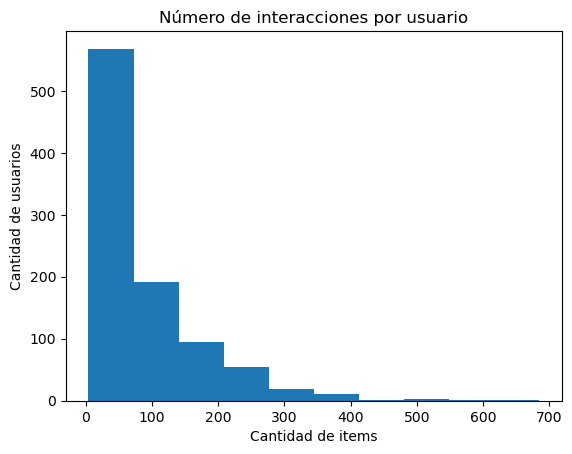

In [7]:
import matplotlib.pyplot as plt

distrib = train_file.groupby(['userid']).count().sort_values(by=['itemid'], ascending=False)
x = distrib['itemid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por usuario', xlabel='Cantidad de items', ylabel='Cantidad de usuarios')

[Text(0.5, 1.0, 'Número de interacciones por item'),
 Text(0.5, 0, 'Cantidad de interacciones'),
 Text(0, 0.5, 'Numero de items')]

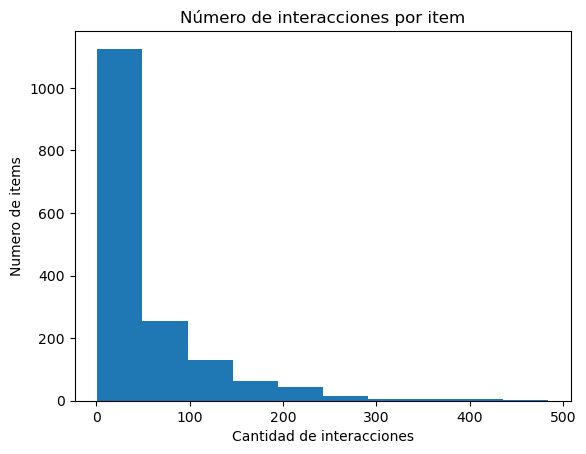

In [8]:
distrib_item = train_file.groupby(['itemid']).count().sort_values(by=['userid'], ascending=False)
x = distrib_item['userid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por item', xlabel='Cantidad de interacciones', ylabel='Numero de items')

Representando la data como histogramas, podemos observar la distribución de las interacciones. Por ejemplo, la primera barra del primer histograma nos indica cuántos usuarios del dataset tienen entre $0$ y $50$ interacciones.

Observe estos datos y comente acerca de la forma de los gráficos y qué significa esta forma en el contexto, tanto para los usuarios como para los ítems. ¿Qué problema podría significar esto para un sistema recomendador?

#### Respuesta:

* Distribución de interacciones por usuario: Como se observa, la mayoría de los usuarios tienen un número relativamente bajo de interacciones, esto podría indicar que algunos usuarios son muy activos en el sistema, mientras que otros solo han interactuado con unas pocas películas. Esta distribución puede ser problemática para un sistema recomendador, ya que los usuarios con pocas interacciones pueden tener perfiles más difíciles de entender y, por lo tanto, hacer recomendaciones precisas para ellos podría ser complicado.
* 
Distribución de interacciones por ítemSimilar al histograma de usuarios, se ve que n una cantidad significativamente mayor de interacciones que otra), esto podría indicar que algunos ítems son muy populares y tienden a ser consumidos por la mayoría de los usuarios, mientras que otros son menos populares y pueden no haber sido descubiertos por muchos usuarios. Esta distribución puede llevar a problemas de "sesgo popular", donde los ítems populares dominan las recomendaciones y los ítems menos populares tienden a ser pasados por alto.

Ambas distribuciones pueden presentar desafíos para un sistema recomendador. En el caso de los usuarios con pocas interacciones, podría haber dificultades para comprender sus preferencias y hacer recomendaciones relevantes. En el caso de los ítems populares, las recomendaciones podrían ser sesgadas y limitar la diversidad de recomendaciciones.

## Como ver la información de una o más películas

Ahora vamos a aprender algunos métodos de la biblioteca de Pandas que nos permiten ver los detalles de algunas interacciones

In [9]:
# Ver la o las filas específicas del usuario con id = 310
train_file[train_file['userid'] == 310]

,userid,itemid,rating,timestamp
17949,310,50,5,879436177
17950,310,294,1,879436712
17951,310,1142,5,879436467
17952,310,1386,1,879436177


Podemos ver que el usuario con ID $310$ tiene $4$ interacciones en el set de entrenamiento

El archivo *u.item* contiene información adicional de cada película, tal como *título*, *fecha de lanzamiento*, *género*, etc.

La columna *movieid* corresponde a la columna *itemid* de nuestra tabla *train_file*, lo que nos permite conectar la información de esta tabla con nuestro dataset original.

In [10]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [11]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [12]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.


Para ver la información de más de una película, se realizan los siguientes pasos
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

Por ejemplo, veamos cuáles fueron las $4$ películas que vio el usuario $310$

In [13]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [50,294,1142,1386]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1142,When We Were Kings (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?When%20We%20W...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1386,Tetsuo II: Body Hammer (1992),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Tetsuo+II%3A+...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Para éste código:
1. `pelis = [50,294,1142,1386]` indica que queremos imprimir los detalles de las películas con estos índices. (En este caso, el índice corresponde al movieid)
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [14]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

movieid
50                   Star Wars (1977)
294                  Liar Liar (1997)
1142        When We Were Kings (1996)
1386    Tetsuo II: Body Hammer (1992)
Name: title, dtype: object

## Preparar entorno
Para generar los modelos recomendadores, utilizaremos la librería [***Surprise***](https://github.com/NicolasHug/Surprise) desarrollada por Nicolas Hug.

In [15]:
!pip install scikit-surprise==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 18.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-linux_x86_64.whl size=1368643 sha256=e44fe0e304818c9629a43359d9fb42cb28b3af6fd483563df63081c8345172ab
  Stored in directory: /home/jovyan/.cache/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en esta tarea

In [16]:
import surprise
print(surprise.__version__)
from surprise.model_selection import PredefinedKFold
import numpy as np
from collections import defaultdict

1.1.3


## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [17]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [18]:
# Declarar el objeto recomendador UserKnn
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [19]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [20]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.4420114287810444, details={'actual_k': 6, 'was_impossible': False})

El valor de `est` es la estimación que el modelo hace para el usuario y objeto correspondiente. En este caso, el modelo predice que el usuario $457$ le daría una calificación de $2.44$ al item $37$.

El valor de `r_ui` es el valor real que el usuario le dio al objeto. Si en el set de entrenamiento, existiera un registro de la calificación que le dio el usuario $457$ al item $37$, esta se vería reflejada en ese valor, el cual no necesariamente será el mismo que el valor predicho por el agente. En eeste caso, como el usuario $457$ no ha visto el item $37$, este valor es `None`

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [21]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [22]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [23]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]


Cada item de la lista `top_n` representa una tupla de el ID del ítem recomendado y su calificación predicha.

Usemos ahora la función `.loc` para analizar las películas recomendadas.

In [24]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1347,"Ballad of Narayama, The (Narayama Bushiko) (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Narayama%20Bu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

La biblioteca Surprise tiene un modulo `accuracy` que permite calcular distintas métricas de error, entre ellas el RMSE y el MAE.

Para evaluar un modelo entrenado, utilizamos la función `.test()` sobre el testset, lo que nos permite calcular la diferencia entre los valores predichos y los valores reales para los elementos del set de testeo.

In [25]:
from surprise import accuracy

k_values = [5, 10, 15] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0347
MAE:  0.8197
RMSE: [1.0880066691561228, 1.0470099288376837, 1.034653750064812]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8197339697540738]


### Evaluar en base a error de prediccion (RMSE y MAE)

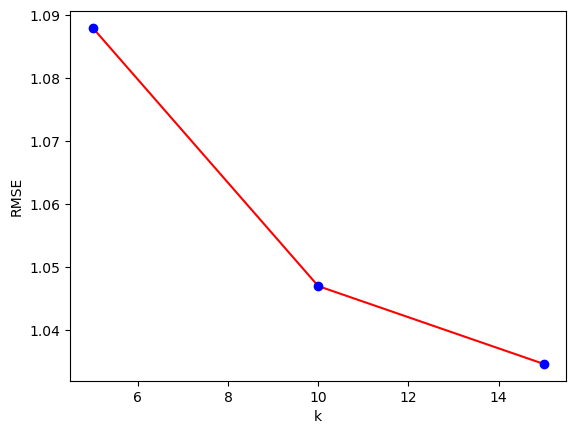

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

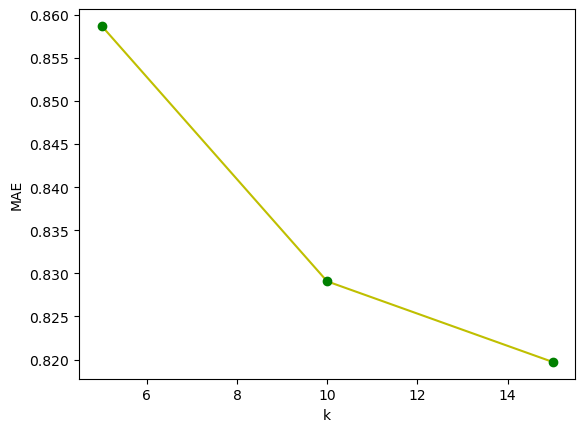

In [27]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

Entrenamos un nuevo agente con valores de `k = 5, 10, 15` y podemos observar que tanto el valor del RMSE y del MAE disminuyeron con un mayor valor de `k`.

### Pregunta 3 (12 puntos):

Continúe el estudio de los hiperparámetros para los valores de `k = 5, 10, 30, 50, 70, 100 y 150`. Grafique sus resultados y conteste:

* Explique, en sus propias palabras, qué se mide con las métricas de RMSE y MAE.
* Qué valor de `k` entrega los mejores resultados.
* Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma.

#### Respuesta:

In [39]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
    
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0248
MAE:  0.8139
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0227
MAE:  0.8136
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0249
MAE:  0.8164
RMSE: [1.0880066691561228, 1.0470099288376837, 1.0248339991369078, 1.0223262772265247, 1.0226955364341241, 1.0249250212627894]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8138754558513105, 0.8125053209390201, 0.8135933998242796, 0.8164173443106846]


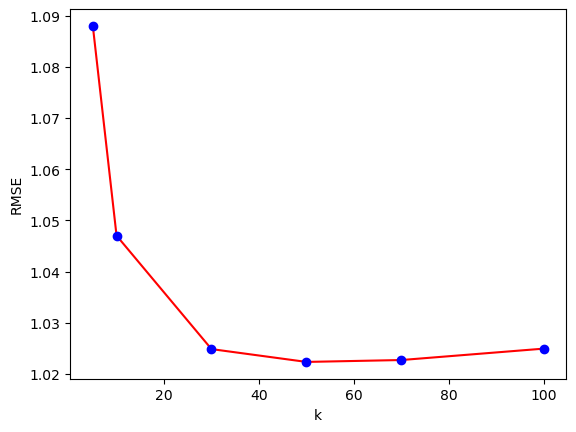

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

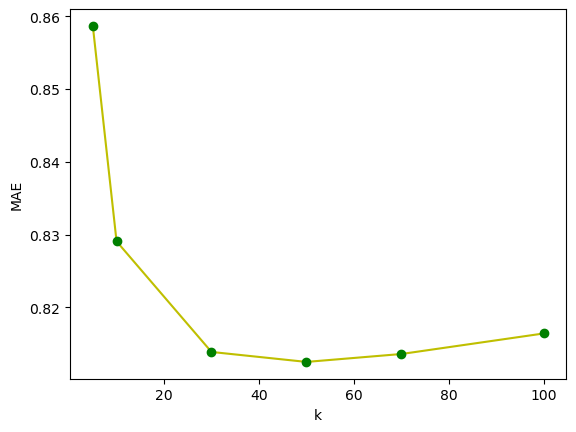

In [31]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

* Explique, en sus propias palabras, qué se mide con las métricas de RMSE y MAE.
 
RMSE (Root Mean Squared Error): En este contexto, el RMSE calcula la raíz cuadrada del promedio de los errores al cuadrado entre las calificaciones reales y las predicciones del modelo KNNBasic. Esto refleja la precisión general del modelo al predecir las calificaciones de los usuarios para las películas. Valores más bajos de RMSE indican que el modelo hace predicciones más cercanas a las calificaciones reales.

MAE (Mean Absolute Error): En este caso, el MAE calcula el promedio de los valores absolutos de los errores entre las calificaciones reales y las predicciones del modelo KNNBasic. Al igual que el RMSE, el MAE también mide la precisión del modelo, pero trata todos los errores por igual sin magnificar errores grandes.

* Qué valor de `k` entrega los mejores resultados.
  
Al observar los resultados vemos que un K  igual a 50 entrega los mejores resultados minimizando el error tanto de la metrica RMSE y MAE.

* Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma.
  
Ocurre que al llegar a un punto igual a 50 el modelo se sobreajusta a los datos de entrenamiento y pierde su poder de generalizar las predicciones que realice por fuere de este dataset.
s.

### Pregunta 4 (12 puntos):

Repita el experimento anterior, pero utilizando los algoritmos de IKNN y [FunkSVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) de la biblioteca Surprise. Recuerde evaluar el rendimiento de sus modelos para las métricas de RMSE y MAE

* Para el caso de IKnn vuelva a realizar un análisis con los valores de `k = 5, 10, 30, 50, 70, 100` e identifique el valor que entrega el mejor resultado.

#### IKNN (ItemKNN):


In [37]:
k_values = [5, 10, 30, 50, 70, 100]
mae_values_i = []
rmse_values_i = []

for k in k_values:
    myItemKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
    myItemKnn.fit(trainset)
    predictions = myItemKnn.test(testset)
    rmse_values_i.append(accuracy.rmse(predictions))
    mae_values_i.append(accuracy.mae(predictions))

# Identificar el mejor valor de k basado en RMSE o MAE más bajo
best_k_rmse = k_values[rmse_values.index(min(rmse_values_i))]
best_k_mae = k_values[mae_values.index(min(mae_values_i))]

print('Best k based on RMSE:', best_k_rmse)
print('Best k based on MAE:', best_k_mae)
print('RMSE:', rmse_values_i)
print('MAE:', mae_values_i)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2026
MAE:  0.9458
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1183
MAE:  0.8810
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0535
MAE:  0.8310
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0474
MAE:  0.8257
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0489
MAE:  0.8294
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0528
MAE:  0.8364
Best k based on RMSE: 50
Best k based on MAE: 50
RMSE: [1.2026497014602677, 1.1182690148176855, 1.053528288892625, 1.0474114308369047, 1.0488827603028315, 1.0527804024208793]
MAE: [0.9458074771899645, 0.8809797919490109, 0.830956196694298, 0.8257379441539587, 0.8293620137533942, 0.8363912329141866]


In [38]:
min(rmse_values_i)

1.0474114308369047

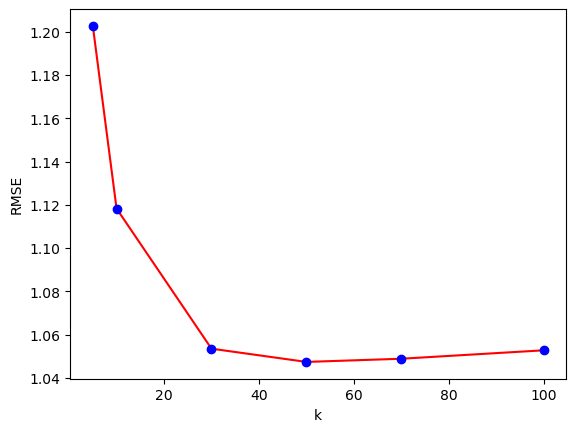

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values_i, 'r-')
plt.plot(k_values, rmse_values_i, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

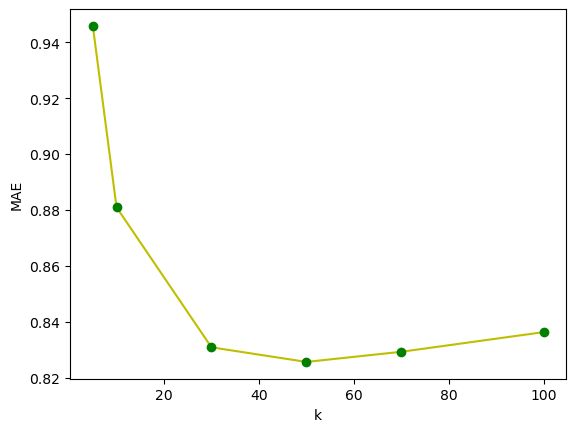

In [34]:
plt.plot(k_values, mae_values_i, 'y-')
plt.plot(k_values, mae_values_i, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

### FunkSVD (SVD):


In [35]:
funk_svd = surprise.SVD()
funk_svd.fit(trainset)
predictions = funk_svd.test(testset)
rmse_funk_svd = accuracy.rmse(predictions)
mae_funk_svd = accuracy.mae(predictions)

print('RMSE (FunkSVD):', rmse_funk_svd)
print('MAE (FunkSVD):', mae_funk_svd)

RMSE: 0.9511
MAE:  0.7480
RMSE (FunkSVD): 0.9510715270183461
MAE (FunkSVD): 0.7479780906418138


#### Respuesta: 

* Dado que el modelo de items (IKNN) estima que el mejor valor de k es 50, significa que después de evaluar el modelo utilizando diferentes valores de k (5, 10, 30, 50, 70, 100), se ha encontrado que k=50 resulta en el rendimiento más óptimo según las métricas de evaluación (RMSE y MAE) para el conjunto de datos y el modelo en cuestión.

* Adicional, el modelo FunkSVD tiene un RMSE de 0.95 y un MAE de 0.74. Esto indica que el modelo está haciendo predicciones con una precisión moderada en relación con las calificaciones reales de los usuarios en el conjunto de datos MovieLens-100k.

### Pregunta 5 (12 puntos):

Genere una tabla que compare los resultados de los métodos de UKnn, IKnn y FunkSVD tanto para RMSE como para MAE. En el caso de IKnn y UKnn, solo utilice el modelo con el valor de `k` que haya entregado los mejores resultados. Identifique qué método logró el mejor resultado para ambas métricas.

Comente acerca de estos resultados. Explique por qué cree que se obtuvieron estos resultados utilizando la materia aprendida en el curso respecto al funcionamiento de cada método.

In [45]:
rmse_values_i[3]

1.0474114308369047

In [50]:
# Valores de RMSE y MAE para los modelos
# Crear DataFraame
data = {
    'RMSE (IKNN)': rmse_values_i,
    'MAE (IKNN)': mae_values_i,
    'RMSE (UKNN)': rmse_values,
    'MAE (UKNN)': mae_values,
    'RMSE (FunkSVD)': rmse_funk_svd,
    'MAE (FunkSVD)': mae_funk_svd
}

df_results = pd.DataFrame(data)

# Mostrar DataFrame con los resultados
df_results.iloc[3].to_frame().rename(columns = {3:"K=50"})

,K=50
RMSE (IKNN),1.047411
MAE (IKNN),0.825738
RMSE (UKNN),1.022326
MAE (UKNN),0.812505
RMSE (FunkSVD),0.951072
MAE (FunkSVD),0.747978


#### Respuesta:

Según el RMSE, FunkSVD (SVD) ha obtenido el mejor resultado, con un valor de 0.9511, lo que indica que este método tiene las predicciones más cercanas a las calificaciones reales.

Según el MAE, también FunkSVD (SVD) ha obtenido el mejor resultado, con un valor de 0.7480, lo que sugiere que este método tiene la menor diferencia promedio entre las predicciones y las calificaciones reales.

En relación lo aprendidoda en el curso


IKNN y UKNN: Estos son métodos de filtrado colaborativo basados en vecindario, que utilizan similitud entre usuarios o ítems para hacer predicciones. Los resultados pueden variar según el valor de k, que determina cuántos vecinos se consideran. Los mejores valores de k son aquellos que encuentran un equilibrio entre la complejidad del modelo y la capacidad de generalización. En este caso, k=50 fue identificado como el mejor valor para ambos métodos basados en el análisis de RMSE y 

E.

FunkSVD: Este es un método de factorización matricial que modela las calificaciones como productos de factores latentes. FunkSVD busca encontrar estos factores que representan características latentes en los datos. En este caso, FunkSVD obtuvo los mejores resultados en ambas métricas, lo que sugiere que el modelo de factorización matricial fue capaz de capturar patrones y relaciones subyacentes en los datos de manera efectiva.

### Pregunta 6 (12 puntos):

Escoja un usuario del set de datos e imprima los títulos de las películas que ha visto (según el set de entrenamiento) y su calificación. Luego, imprima una lista de 5 recomendaciones entregadas para este usuario por cada uno de los $3$ modelos entrenados y compare estas listas. Comparando los gustos en la historia del usuario y las recomendaciones entregadas por los modelos, le hacen sentido estas recomendaciones. (Su respuesta no necesariamente debe coincidir con las conclusiones finales de la sección experimental).

Evite usar a los usuarios 457 y 310 que ya fueron estudiados en la tarea. Recuerde imprimir al menos los títulos de cada película, tanto en la historia del usuario como en las recomendaciones para poder identificarlas correctamente.

#### Respuesta: